# Classifying textures in outex68 using TDA

In [1]:
from gtda.plotting import plot_heatmap
from skimage import io
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
import gudhi as gd
import gudhi.representations
import extract_featurized_barcodes as ex

## Preparing the dataset

We will try to classify outex-68. First, we load the .bmp images as matrixes. It will take some seconds.

In [2]:
folder = 'Outex-TC-00024/images'
images_names = os.listdir(folder)
images_names = list(filter(lambda x : x[0]!='.', images_names))

In [3]:
images_matrixes = np.array(list(map(lambda x : io.imread(folder+'/'+x), images_names)), dtype=float)

Then, we pick the names of the training and test images and their labels.

In [4]:
train_names = pd.read_csv("/home/manu/review/Outex-TC-00024/000/train.txt", sep=" ", usecols=[0]).to_numpy().flatten().tolist()
train_labels = pd.read_csv("/home/manu/review/Outex-TC-00024/000/train.txt", sep=" ", usecols=[1]).to_numpy().flatten().tolist()
test_names = pd.read_csv("/home/manu/review/Outex-TC-00024/000/test.txt", sep=" ", usecols=[0]).to_numpy().flatten().tolist()
test_labels = pd.read_csv("/home/manu/review/Outex-TC-00024/000/test.txt", sep=" ", usecols=[1]).to_numpy().flatten().tolist()

Using the file names, we will load the train and test images. Note that they will keep the same order than the labels. We will also use the images with the greyscale inverted.

In [5]:
train_indexes = list(map(lambda x : images_names.index(x), train_names))
test_indexes = list(map(lambda x : images_names.index(x), test_names))

We are using only 10 classes from the original dataset. In order to perform the experiment with the 68 classes, comment the following cell.

In [6]:
from numpy.random import choice
labels = np.array(list(set(test_labels)))
labels = choice(labels, size=(10), replace = False)
    
train_indexes = [train_indexes[i] for i in range(len(train_indexes)) if train_labels[i] in labels]
train_labels = [i for i in train_labels if i in labels]
test_indexes = [test_indexes[i] for i in range(len(test_indexes)) if test_labels[i] in labels]
test_labels = [i for i in test_labels if i in labels]

Finally, we load the images and their inverse.

In [7]:
images_gudhi = np.array(list(map(lambda x : x.reshape(128*128,1), images_matrixes)))
train_gudhi =  images_gudhi[train_indexes]
test_gudhi = images_gudhi[test_indexes]

train_gudhi_opp =  255-train_gudhi
test_gudhi_opp = 255-train_gudhi

## Calculating the persistence diagrams

We use the filter function for cubical complexes to obtain the persistence diagrams. We obtain 4 diagrams from each image: dimension 0 and 1 of the original image and the inverted one. It takes around 10 minutes to run.

In [8]:
cub_filtration = lambda image : gd.CubicalComplex(dimensions = [128,128], top_dimensional_cells=image)
calculate_pd = lambda image : cub_filtration(image).persistence()

train_pds = list(map(calculate_pd, train_gudhi))
test_pds = list(map(calculate_pd, test_gudhi))
train_pds_opp = list(map(calculate_pd, train_gudhi_opp))
test_pds_opp = list(map(calculate_pd, test_gudhi_opp))

In [9]:
#The representation module does not deal well with infinity, so we change it by 256.
infty_proj = lambda x : 256 if ~np.isfinite(x) else x

In [10]:
intervals_of_dim_0 = lambda pd : np.array([[x[1][0], infty_proj(x[1][1])]  for x in pd if x[0]==0])
train_pds_0 = list(map(intervals_of_dim_0, train_pds))
test_pds_0 = list(map(intervals_of_dim_0, test_pds))
train_pds_opp_0 = list(map(intervals_of_dim_0, train_pds_opp))
test_pds_opp_0 = list(map(intervals_of_dim_0, test_pds_opp))

In [11]:
intervals_of_dim_1 = lambda pd : np.array([[x[1][0], infty_proj(x[1][1])]  for x in pd if x[0]==1])
train_pds_1 = list(map(intervals_of_dim_1, train_pds))
test_pds_1 = list(map(intervals_of_dim_1, test_pds))
train_pds_opp_1 = list(map(intervals_of_dim_1, train_pds_opp))
test_pds_opp_1 = list(map(intervals_of_dim_1, test_pds_opp))

## Classification with the Betti Curve

We perform a classification task using the betti curve and Random Forest. We concatenate the four betti curves obtained from each image, and then feed the classifier with them. It takes 1 minutes.

In [12]:
res = 100
train_Btt_0 = [ex.GetBettiCurveFeature(pd, res) for pd in train_pds_0]
train_Btt_1 = [ex.GetBettiCurveFeature(pd, res) for pd in train_pds_1]
test_Btt_0 = [ex.GetBettiCurveFeature(pd, res) for pd in test_pds_0]
test_Btt_1 = [ex.GetBettiCurveFeature(pd, res) for pd in test_pds_1]
train_Btt_opp_0 = [ex.GetBettiCurveFeature(pd, res) for pd in train_pds_opp_0]
train_Btt_opp_1 = [ex.GetBettiCurveFeature(pd, res) for pd in train_pds_opp_1]
test_Btt_opp_0 = [ex.GetBettiCurveFeature(pd, res) for pd in test_pds_opp_0]
test_Btt_opp_1 = [ex.GetBettiCurveFeature(pd, res) for pd in test_pds_opp_1]
train_Btt = [np.concatenate([dgm0,dgm1,dgm2,dgm3]) for dgm0,dgm1,dgm2,dgm3 in zip(train_Btt_0, train_Btt_1, train_Btt_opp_0, train_Btt_opp_1)]
test_Btt = [np.concatenate([dgm0,dgm1,dgm2,dgm3]) for dgm0,dgm1,dgm2,dgm3 in zip(test_Btt_0, test_Btt_1, test_Btt_opp_0, test_Btt_opp_1)]

Example of how the curves look like after the concatenation.

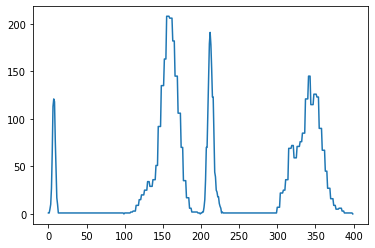

In [13]:
plt.plot(train_Btt[0])

In [14]:
classifier = RandomForestClassifier()
classifier = classifier.fit(train_Btt, train_labels)   

In [24]:
train_Btt[0].shape

(400,)

In [25]:
np.asarray(train_Btt).shape

(200, 400)

In [22]:
len(train_labels)

200

In this example, the accuracy is the following

In [15]:
print("Train accuracy = " + str(classifier.score(train_Btt, train_labels)))
print("Test accuracy  = " + str(classifier.score(test_Btt, test_labels))) 

Train accuracy = 1.0
Test accuracy  = 0.965


## Classification with PersStats

We use here persistent stats. It takes less than one minute.

In [16]:
train_Sta_0 = [ex.GetPersStats(pd) for pd in train_pds_0]
train_Sta_1 = [ex.GetPersStats(pd) for pd in train_pds_1]
test_Sta_0 = [ex.GetPersStats(pd) for pd in test_pds_0]
test_Sta_1 = [ex.GetPersStats(pd) for pd in test_pds_1]
train_Sta_opp_0 = [ex.GetPersStats(pd) for pd in train_pds_opp_0]
train_Sta_opp_1 = [ex.GetPersStats(pd) for pd in train_pds_opp_1]
test_Sta_opp_0 = [ex.GetPersStats(pd) for pd in test_pds_opp_0]
test_Sta_opp_1 = [ex.GetPersStats(pd) for pd in test_pds_opp_1]
train_Sta = [np.concatenate([dgm0,dgm1,dgm2,dgm3]) for dgm0,dgm1,dgm2,dgm3 in zip(train_Btt_0, train_Btt_1, train_Btt_opp_0, train_Btt_opp_1)]
test_Sta = [np.concatenate([dgm0,dgm1,dgm2,dgm3]) for dgm0,dgm1,dgm2,dgm3 in zip(test_Btt_0, test_Btt_1, test_Btt_opp_0, test_Btt_opp_1)]

In [17]:
classifier = RandomForestClassifier()
classifier = classifier.fit(train_Sta, train_labels)  

In [18]:
print("Train accuracy = " + str(classifier.score(train_Btt, train_labels)))
print("Test accuracy  = " + str(classifier.score(test_Btt, test_labels))) 

Train accuracy = 1.0
Test accuracy  = 0.955


## Classification with Persistence Images

We use here persistent stats. It takes less than five minute.

In [19]:
res = [6,6]

train_PI_0 = [ex.GetPersImageFeature(pd,res) for pd in train_pds_0]
train_PI_1 = [ex.GetPersImageFeature(pd,res) for pd in train_pds_1]
test_PI_0 = [ex.GetPersImageFeature(pd,res) for pd in test_pds_0]
test_PI_1 = [ex.GetPersImageFeature(pd,res) for pd in test_pds_1]
train_PI_opp_0 = [ex.GetPersImageFeature(pd,res) for pd in train_pds_opp_0]
train_PI_opp_1 = [ex.GetPersImageFeature(pd,res) for pd in train_pds_opp_1]
test_PI_opp_0 = [ex.GetPersImageFeature(pd,res) for pd in test_pds_opp_0]
test_PI_opp_1 = [ex.GetPersImageFeature(pd,res) for pd in test_pds_opp_1]
train_PI = [np.concatenate([dgm0,dgm1,dgm2,dgm3]) for dgm0,dgm1,dgm2,dgm3 in zip(train_Btt_0, train_Btt_1, train_Btt_opp_0, train_Btt_opp_1)]
test_PI = [np.concatenate([dgm0,dgm1,dgm2,dgm3]) for dgm0,dgm1,dgm2,dgm3 in zip(test_Btt_0, test_Btt_1, test_Btt_opp_0, test_Btt_opp_1)]

In [20]:
classifier = RandomForestClassifier()
classifier = classifier.fit(train_PI, train_labels)  

In [21]:
print("Train accuracy = " + str(classifier.score(train_PI, train_labels)))
print("Test accuracy  = " + str(classifier.score(test_PI, test_labels))) 

Train accuracy = 1.0
Test accuracy  = 0.95
